# Demo 1: Decision Trees
---

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand Decision Trees**: Explain how a single decision tree makes predictions through recursive splitting to partition data into discrete classes, such as water and non-water.
2. **Transform Data for ML**: Practice turning raw geospatial data into numbers and table formats so a computer can find patterns using code and math.
3. **Execute a Supervised Workflow**: Perform an end-to-end supervised learning project where the algorithm learns classification rules from labeled examples to generate a predictive map

## A. Introduction and Setup

Let's start by importing the necessary libraries and setting up our environment for reproducible results.

In [ ]:
# Core scientific computing libraries
import numpy as np
import matplotlib.pyplot as plt

# Geospatial data handling
import rasterio

# Scikit-learn for machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Visualization and layout tools
from matplotlib.colors import ListedColormap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported successfully!")
print(f"✓ Random state set to: {RANDOM_STATE}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Rasterio version: {rasterio.__version__}")

✓ Libraries imported successfully!
✓ Random state set to: 42
✓ NumPy version: 2.0.2
✓ Rasterio version: 1.4.4


---

## B. Decision Trees Interactive Demo

### What is a Decision Tree?

A **Decision Tree** is a supervised learning algorithm that makes predictions by learning a series of if-then-else decision rules from data. Think of it like a flowchart:

```
Is NDVI > 0.3?
├─ Yes: Is NIR > 0.5?
│  ├─ Yes: Forest
│  └─ No: Grassland
└─ No: Is SWIR < 0.2?
   ├─ Yes: Water
   └─ No: Urban
```

### Key Concepts:

- **Root Node**: The first decision point (top of the tree)
- **Internal Nodes**: Intermediate decision points
- **Leaf Nodes**: Final predictions (bottom of the tree)
- **Splitting**: How the algorithm decides which feature and threshold to use
- **Depth**: Number of levels in the tree (deeper = more complex)

### Let's Build a Simple Example:

#### 1. Data Loading and Feature Engineering

In this section, we load the multispectral satellite data and create proxy labels for water detection using spectral indices (NDVI and NDWI).

**NDVI (Normalized Difference Vegetation Index):**
- Used to quantify vegetation greenness and is useful in understanding vegetation density.
- Formula:   NDVI = (NIR + Red) / (NIR − Red)

**NDWI (Normalized Difference Water Index):**
- Used for delineating and monitoring content changes in surface water
- Formula:   NDWI = (Green + NIR) / (Green − NIR)

In [ ]:
# Load Data
file_path = "test_image.tif"

with rasterio.open(file_path) as src:
    # Read and flatten bands
    green = src.read(2).flatten()
    red   = src.read(3).flatten()
    nir   = src.read(4).flatten()

    # Store metadata for reconstruction
    height, width = src.height, src.width
    rgb_raw = src.read([4, 3, 2])

# Generate Proxy Labels (Ground Truth)
ndwi_label = (green - nir) / (green + nir + 1e-6)
ndvi_label = (nir - red) / (nir + red + 1e-6)

# Create binary water mask: High NDWI AND Low NDVI
y_water_proxy = np.zeros_like(ndwi_label)
y_water_proxy[(ndwi_label > 0.0) & (ndvi_label < 0.2)] = 1

print(f"✓ Image Dimensions: {height}x{width}")
print(f"✓ Total Pixels: {len(ndwi_label)}")
print(f"✓ Proxy Water Pixels: {int(np.sum(y_water_proxy))}")

✓ Image Dimensions: 74x76
✓ Total Pixels: 5624
✓ Proxy Water Pixels: 3229


#### 2. Model Training and Prediction

We will now train a Decision Tree classifier to recognize "water" based on the spectral signatures of the Green, Red, and NIR bands.

In [ ]:
# Prepare Training Data

# Filter out invalid (zero) pixels to improve training quality
valid_mask = (red > 0) & (nir > 0) & (green > 0)
X = np.stack([green[valid_mask], red[valid_mask], nir[valid_mask]], axis=1)
y = y_water_proxy[valid_mask]

# Data Inspection
print("📊 Dataset Statistics:")
print("━" * 30)
print(f"Dataset shape:      {X.shape} (Pixels, Bands)")
print(f"Number of samples:  {X.shape[0]}")
print(f"Number of features: {X.shape[1]} (Green, Red, NIR)")
print(f"Classes:            {np.unique(y)} (0: Non-water, 1: Water)")

# Calculate distribution
counts = np.bincount(y.astype(int))
print(f"Class distribution: Non-Water: {counts[0]}, Water: {counts[1]}")
print("━" * 30)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE
)

📊 Dataset Statistics:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Dataset shape:      (5624, 3) (Pixels, Bands)
Number of samples:  5624
Number of features: 3 (Green, Red, NIR)
Classes:            [0. 1.] (0: Non-water, 1: Water)
Class distribution: Non-Water: 2395, Water: 3229
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [ ]:
# Train Model
water_model = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
water_model.fit(X_train, y_train)

# Evaluation Metrics
train_accuracy = water_model.score(X_train, y_train)
test_accuracy = water_model.score(X_test, y_test) # Checking against unseen data

print(f"📊 Model Performance:")
print(f"✓ Training Accuracy: {train_accuracy:.3f}")
print(f"✓ Tree Depth:       {water_model.get_depth()}")
print(f"✓ Number of Leaves: {water_model.get_n_leaves()}")

# Generate Map for the entire image
X_full = np.stack([green, red, nir], axis=1)
predictions = water_model.predict(np.nan_to_num(X_full))
water_map = predictions.reshape(height, width)

print(f"✓ Full image prediction complete.")

📊 Model Performance:
✓ Training Accuracy: 0.984
✓ Tree Depth:       3
✓ Number of Leaves: 7
✓ Full image prediction complete.


#### 3. Visualization and Results

Finally, we compare our predicted water map against the True Color (RGB) reference image to evaluate the model's performance.

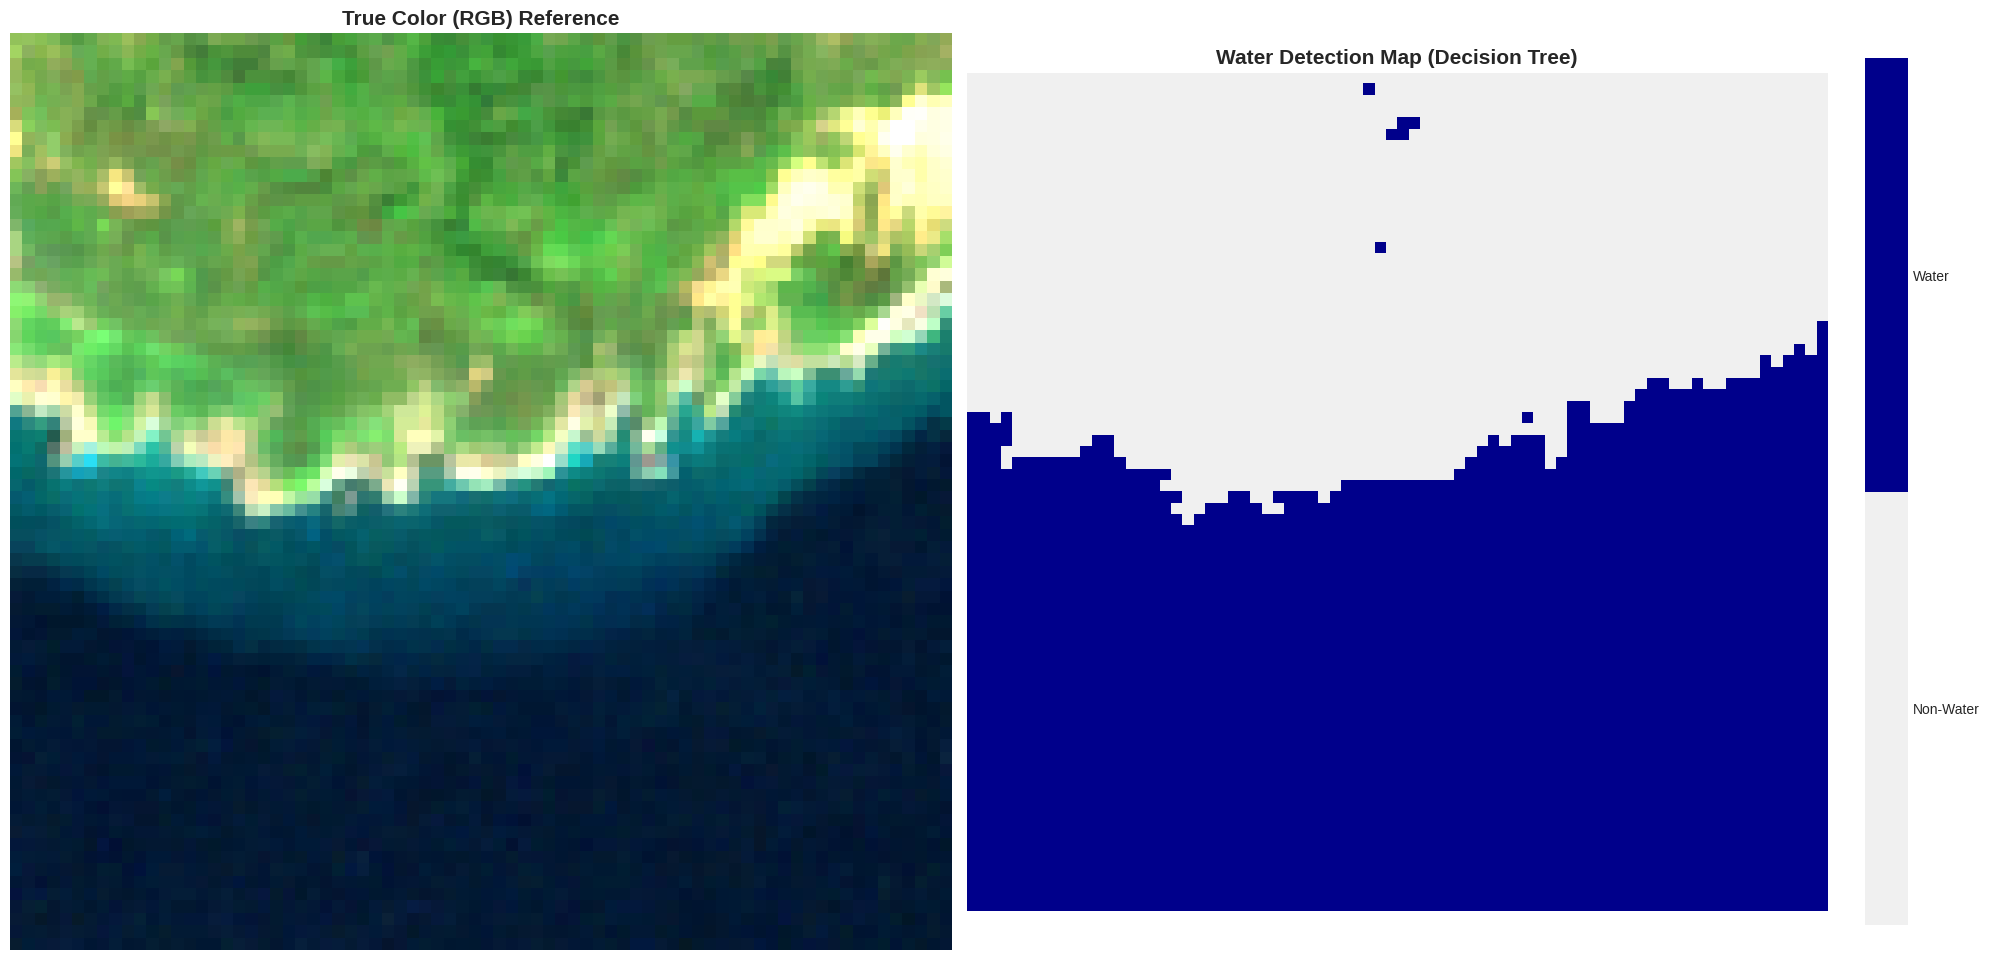


💡 TIP: Decision Trees are great for EO because they create clear 'if-then' rules
based on spectral thresholds, making the classification process easy to interpret.


In [ ]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

# Plot 1: RGB Reference
# Perform a 2% linear stretch for better visualization
rgb = rgb_raw.transpose(1, 2, 0).astype(float)
p2, p98 = np.percentile(rgb, (2, 98))
rgb_stretched = np.clip((rgb - p2) / (p98 - p2), 0, 1)

ax1.imshow(rgb_stretched)
ax1.set_title("True Color (RGB) Reference", fontsize=15, fontweight='bold')
ax1.axis('off')

# Plot 2: Water Map
water_cmap = ListedColormap(['#f0f0f0', '#00008b']) # Light grey and Deep Blue
im = ax2.imshow(water_map, cmap=water_cmap)
ax2.set_title("Water Detection Map (Decision Tree)", fontsize=15, fontweight='bold')
ax2.axis('off')

# Add Legend
cbar = plt.colorbar(im, ax=ax2, ticks=[0.25, 0.75], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['Non-Water', 'Water'])

plt.tight_layout()
plt.show()

print("\n💡 TIP: Decision Trees are great for EO because they create clear 'if-then' rules")
print("based on spectral thresholds, making the classification process easy to interpret.")

### Visualize the Tree Structure

Let's look inside the tree to see the actual decision rules it learned.

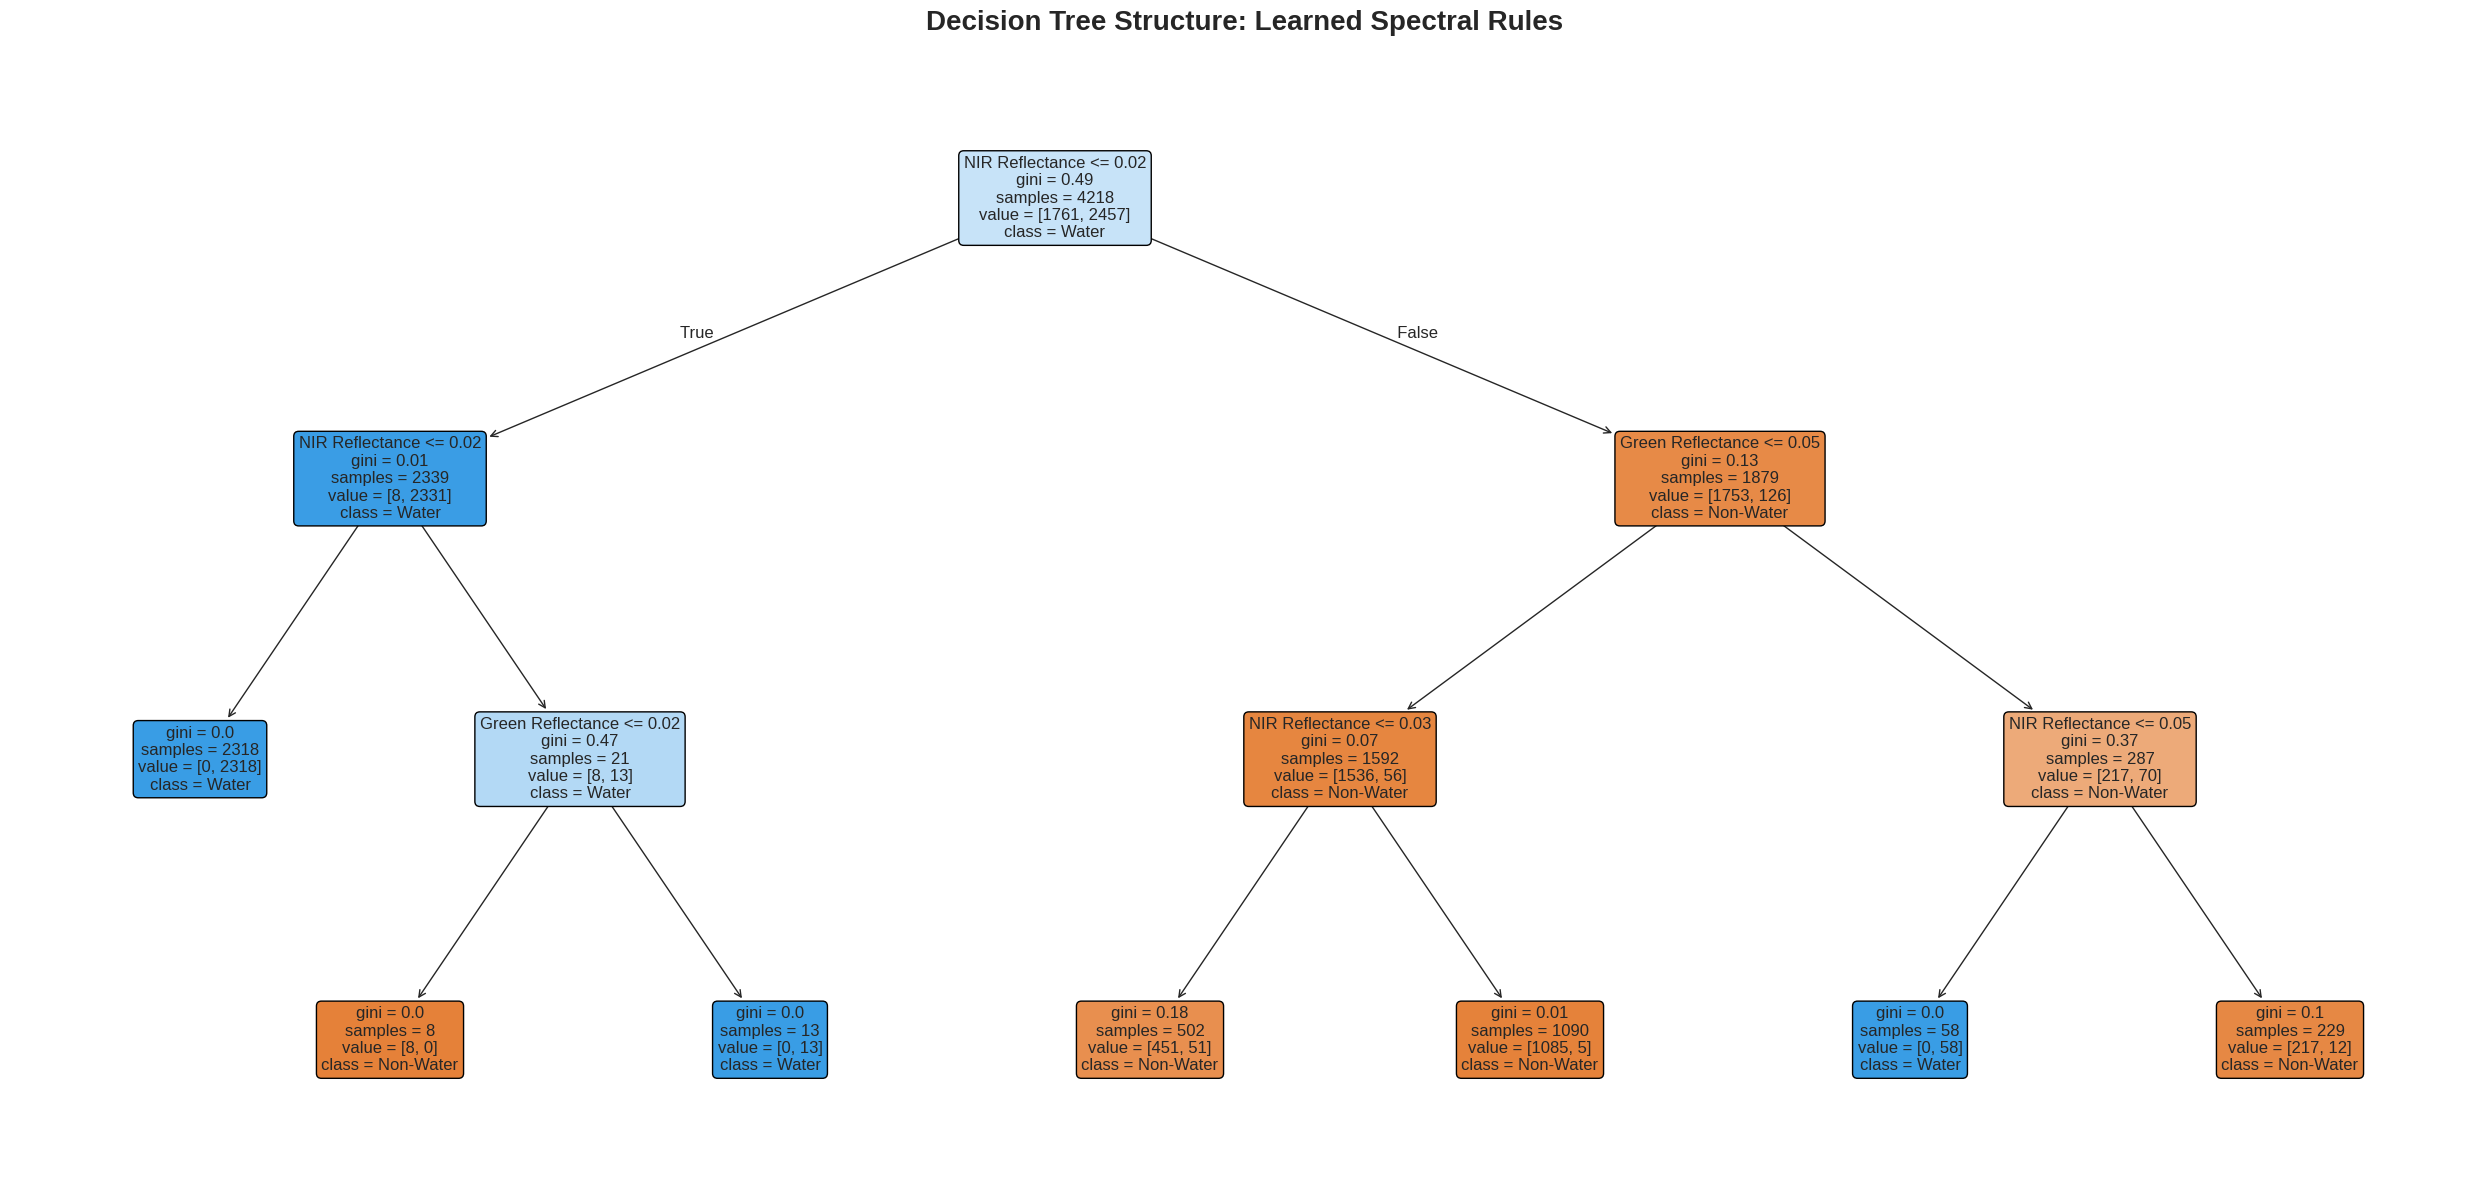


How to Read This Tree:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Each box is a node with a decision rule (e.g., 'NIR <= 120.5')
• 'gini' measures impurity (0 = pure, 0.5 = mixed)
• 'samples' shows how many training pixels reach this node
• 'value' shows pixel distribution [Non-Water, Water]
• Color intensity indicates class majority (darker Blue = Water, darker Orange = Non-Water)
• Leaf nodes (bottom) make the final classification for your map


In [ ]:
from sklearn.tree import plot_tree

# Configure the visual parameters
plt.figure(figsize=(25, 12)) # Wider figure for better readability

# Plot the tree structure
# Note: We limit max_depth to 3 for the visualization so it stays readable
plot_tree(water_model,
         feature_names=['Green Reflectance', 'Red Reflectance', 'NIR Reflectance'],
         class_names=['Non-Water', 'Water'],
         max_depth=3,
         filled=True,
         rounded=True,
         fontsize=12,
         precision=2)

plt.title('Decision Tree Structure: Learned Spectral Rules', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nHow to Read This Tree:")
print("━" * 60)
print("• Each box is a node with a decision rule (e.g., 'NIR <= 120.5')")
print("• 'gini' measures impurity (0 = pure, 0.5 = mixed)")
print("• 'samples' shows how many training pixels reach this node")
print("• 'value' shows pixel distribution [Non-Water, Water]")
print("• Color intensity indicates class majority (darker Blue = Water, darker Orange = Non-Water)")
print("• Leaf nodes (bottom) make the final classification for your map")

---

## Summary and Key Takeaways

### Decision Trees
- Learn hierarchical decision rules through recursive splitting
- Create axis-aligned decision boundaries
- Prone to overfitting if too deep
- Easy to interpret and visualize

#### Advantages:

- Easy to understand and visualize
- No data normalization needed
- Handles non-linear relationships
- Feature importance easily extracted
- Fast prediction

#### Limitations:
- **Overfitting**: Can memorize training data
- **High variance**: Small data changes → big tree changes
- **Instability**: Greedy algorithm (local optima)
- **Bias**: Favor features with many levels

---

## References

1. CoPhil EO AI/ML Training Programme. (2025). Core Concepts of AI/ML for Earth Observation. https://skotsopoulos-del.github.io/cophil-training-v1.0/day1/sessions/session2.html

---

**End of Demo 1 Notebook**
